### Figure 4 
- Sliding template during sleep deprivation
- Correlation across time window

### load data

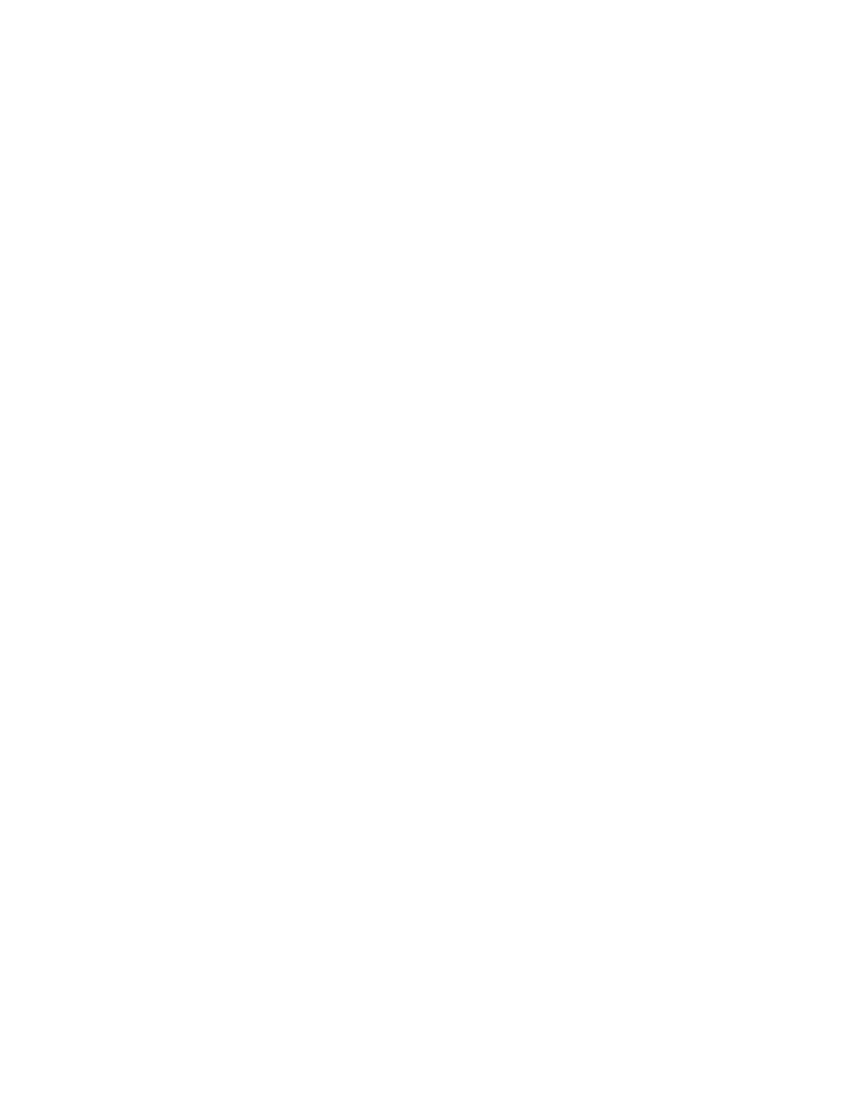

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from subjects import boxplot_kw
import subjects
import pandas as pd
import seaborn as sns
from neuropy.plotting.dataviz import barplot
from neuropy.plotting import Fig
from scipy import stats

group = ['NSD','SD']
grpdata = subjects.GroupData()
pf_norm_tuning = grpdata.pf_norm_tuning


# replay examples
examples = grpdata.replay_examples

#replay rate
wcorr_dist = grpdata.replay_wcorr
# post replay score
post_df = grpdata.replay_post_score
# post_df = post_df[np.abs(post_df['velocity'])>100]
post_df['weighted_corr'] = post_df['weighted_corr'].abs()
colors_post = subjects.colors_sd(1)


fig = Fig(grid=(6, 6), hspace=0.45, wspace=0.5)
filename = subjects.figpath_sd / 'figure4'
caption = 'Place cells: \n(A) Place fields recorded during NSD and SD sessions.'

### replay examples

In [9]:
subfig = fig.add_subfigure(fig.gs[1, 0:3])
axs = subfig.subplots(2, 8, sharey="row")

dt = 0.02*1000
pf_cmaps = ['Greys','Reds']
for i, g in enumerate(group):
    events = examples[g]["posteriors"]
    wcorr = examples[g]['wcorr']
    for i1, ev in enumerate(events):
        ev = np.apply_along_axis(
            np.convolve, axis=0, arr=ev, v=np.ones(2 * 2 + 1), mode="same"
        )
        nt = ev.shape[1]
        ax = axs[i,i1]
        ax.pcolormesh(ev, cmap=pf_cmaps[i], vmin=0, vmax=0.2,rasterized=True)
        ax.text(0.6,7,f'{wcorr[i1].round(2)}',color='#039be5',fontdict=dict(fontsize=6))
        ax.spines['right'].set_visible(True)
        ax.spines['top'].set_visible(True)
        ax.set_yticks([])
        ax.set_xticks([nt//2],[int(nt*dt)])
        ax.tick_params(length=0)


### wcorr distribution

In [10]:
subfig = fig.add_subfigure(fig.gs[:2, 3:4])
axs = subfig.subplots(4, 1, sharex=True)

for i, t in enumerate(wcorr_dist.zt.unique()):
    df = wcorr_dist[wcorr_dist.zt == t]
    d1 = df[df.grp == "NSD"].perc.values
    d2 = df[df.grp == "SD"].perc.values
    ax = axs[i]
    sns.histplot(
        data=df,
        x="perc",
        hue="grp",
        palette=subjects.colors_sd(1.2),
        ax=ax,
        common_norm=False,
        common_bins=True,
        stat='probability',
        element='poly',
        fill=False,
        # cumulative=True,
    )
    ax.legend([], frameon=False)
    if i>0:
        ax.set_ylim([0.02,0.06])
    print(stats.kstest(d1, d2))


KstestResult(statistic=0.051826529046961625, pvalue=1.405943731444038e-05)
KstestResult(statistic=0.019783974311321284, pvalue=0.006745520610021697)
KstestResult(statistic=0.03265959575981153, pvalue=2.1671034619594534e-06)
KstestResult(statistic=0.02720489172247311, pvalue=0.0021422282472460807)


### wcorr sequence score 

In [11]:
ax = fig.subplot(fig.gs[3, 3])
sns.barplot(
    data=wcorr_dist,
    x="zt",
    y="seq_score",
    hue="grp",
    ax=ax,
    ci=99,
    capsize=0.2,
    palette=subjects.colors_sd(1.2),
)

ax.tick_params('x',rotation=45)
ax.legend('',frameon=False)

### saving

In [12]:
# fig.savefig(filename,caption=caption)